In [87]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import show_images

In [88]:
cuadro0 = cv2.imread('img/cuadro_0.jpg', cv2.IMREAD_GRAYSCALE) # --> source image 
cuadro1 = cv2.imread('img/cuadro_1.jpg', cv2.IMREAD_GRAYSCALE)  # --> destination image 1  
cuadro2 = cv2.imread('img/cuadro_2.jpg', cv2.IMREAD_GRAYSCALE) # --> destination image  2

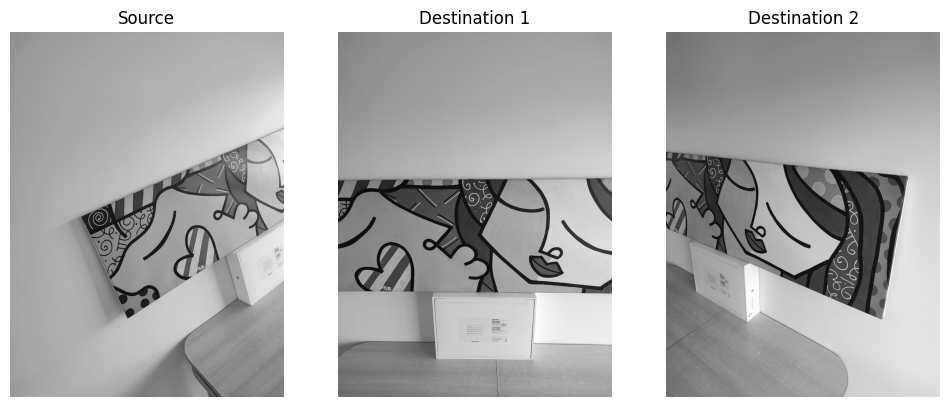

In [89]:
# Display images
show_images([cuadro0, cuadro1, cuadro2], ["Source", "Destination 1", "Destination 2"])

In [75]:
# Check image sizes
print('Source Image Size:', cuadro0.shape)
print('Destination Image 1 Size:', cuadro1.shape)
print('Destination Image 2 Size:', cuadro2.shape)

Source Image Size: (4096, 3072)
Destination Image 1 Size: (4096, 3072)
Destination Image 2 Size: (4096, 3072)


In [90]:
# Busqueda de keypoints y descriptores
algo = cv2.SIFT_create()
kp0, des0 = algo.detectAndCompute(cuadro0, None)
kp1, des1 = algo.detectAndCompute(cuadro1, None)
kp2, des2 = algo.detectAndCompute(cuadro2, None)

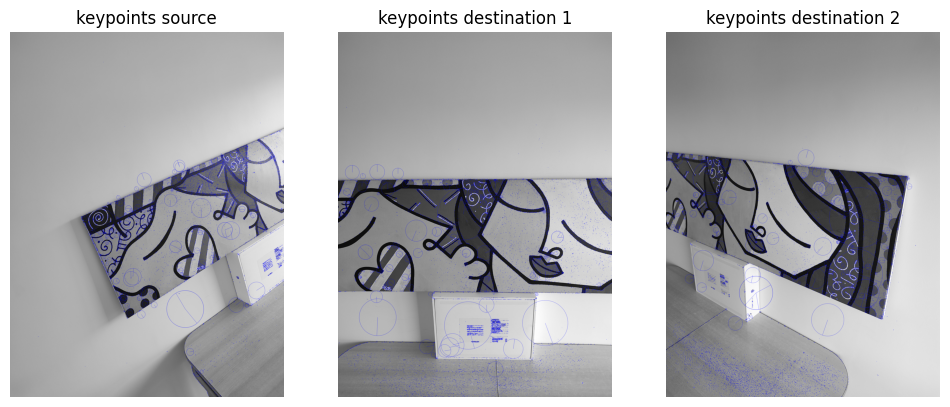

In [91]:
kp_cuadro0 = cv2.cvtColor(cuadro0, cv2.COLOR_GRAY2BGR)
kp_cuadro1 = cv2.cvtColor(cuadro1, cv2.COLOR_GRAY2BGR)
kp_cuadro2 = cv2.cvtColor(cuadro2, cv2.COLOR_GRAY2BGR)

# Display keypoints
kp_cuadro0 = cv2.drawKeypoints(kp_cuadro0, kp0, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_cuadro1 = cv2.drawKeypoints(kp_cuadro1, kp1, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp_cuadro2 = cv2.drawKeypoints(kp_cuadro2, kp2, 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images
show_images([kp_cuadro0, kp_cuadro1, kp_cuadro2], ["keypoints source", "keypoints destination 1", "keypoints destination 2"])

In [92]:
def anms(keypoints, N):
    """
    Applies Adaptive Non-Maximal Suppression (ANMS) to select the N most relevant keypoints.
    
    Args:
        keypoints (list): List of detected keypoints.
        responses (list): List of responses (strengths) for each keypoint.
        N (int): Number of keypoints to retain after ANMS.

    Returns:
        List of retained keypoints after applying ANMS.
    """
    if len(keypoints) == 0:
        return []
    
    # First sort the keypoints by their response (strength) in descending order
    keypoints = sorted(keypoints, key=lambda x: x.response, reverse=True)

    # Convert keypoints and responses to arrays
    kp_coords = np.array([kp.pt for kp in keypoints])
    kp_responses = np.array([kp.response for kp in keypoints])

    # Initialize the suppression radius with a large value
    radii = np.full(len(keypoints), np.inf)

    # Loop over each keypoint and calculate the suppression radius
    for i in range(len(keypoints)):
        for j in range(len(keypoints)):
            if kp_responses[j] > kp_responses[i]:  # If kp j has a stronger response
                distance = np.linalg.norm(kp_coords[i] - kp_coords[j])  # Euclidean distance
                if distance < radii[i]:  # Update the minimum radius
                    radii[i] = distance

    # Sort keypoints by their radius in descending order
    sorted_indices = np.argsort(radii)[::-1] # [::-1] reverses the array to descending order 
    selected_indices = sorted_indices[:N]  # Select the top N keypoints with the largest radius

    # Return the selected keypoints
    selected_keypoints = [keypoints[i] for i in selected_indices]
    return selected_keypoints

def aply_anms(img, kp, des, N):
    algo = cv2.SIFT_create()
    # Sort keypoints by response
    kp = sorted(kp, key=lambda x: x.response, reverse=True)
    anms_kp = anms(kp0[:5000], N)
    des = algo.compute(img, anms_kp)[1]
    return anms_kp, des

In [94]:
anms_kp0, anms_desc0 = aply_anms(cuadro0, kp0, des0, 100)
anms_kp1, anms_desc1 = aply_anms(cuadro1, kp1, des1, 100)
anms_kp2, anms_desc2 = aply_anms(cuadro2, kp2, des2, 100)

In [96]:
print("Cantidad de keypoints: ", len(anms_kp0), ",", len(anms_kp1), ",", len(anms_kp2))
print("Cantidad de descriptores: ", anms_desc0.shape, ",", anms_desc1.shape, ",", anms_desc2.shape)

Cantidad de keypoints:  100 , 100 , 100
Cantidad de descriptores:  (100, 128) , (100, 128) , (100, 128)


In [100]:
def match_descriptors(des_A, des_B):
    """ Match descriptors from two images (A and B) using the brute force matcher """
    # Matching descriptors
    bf = cv2.BFMatcher( )
    matches = bf.knnMatch(des_A, des_B, k=2) # returns k best matches for each descriptor in the source image 

    # We want matches whose second best match is much worse than the best match (else, is likely to be noise)
    matchesMask = [[0, 0] for i in range(len(matches))]
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.5 * n.distance:
            matchesMask[i] = [1, 0]
    return matches, matchesMask

In [101]:
matches01, matchesMask01 = match_descriptors(anms_desc0, anms_desc1)
matches12, matchesMask12 = match_descriptors(anms_desc1, anms_desc2)

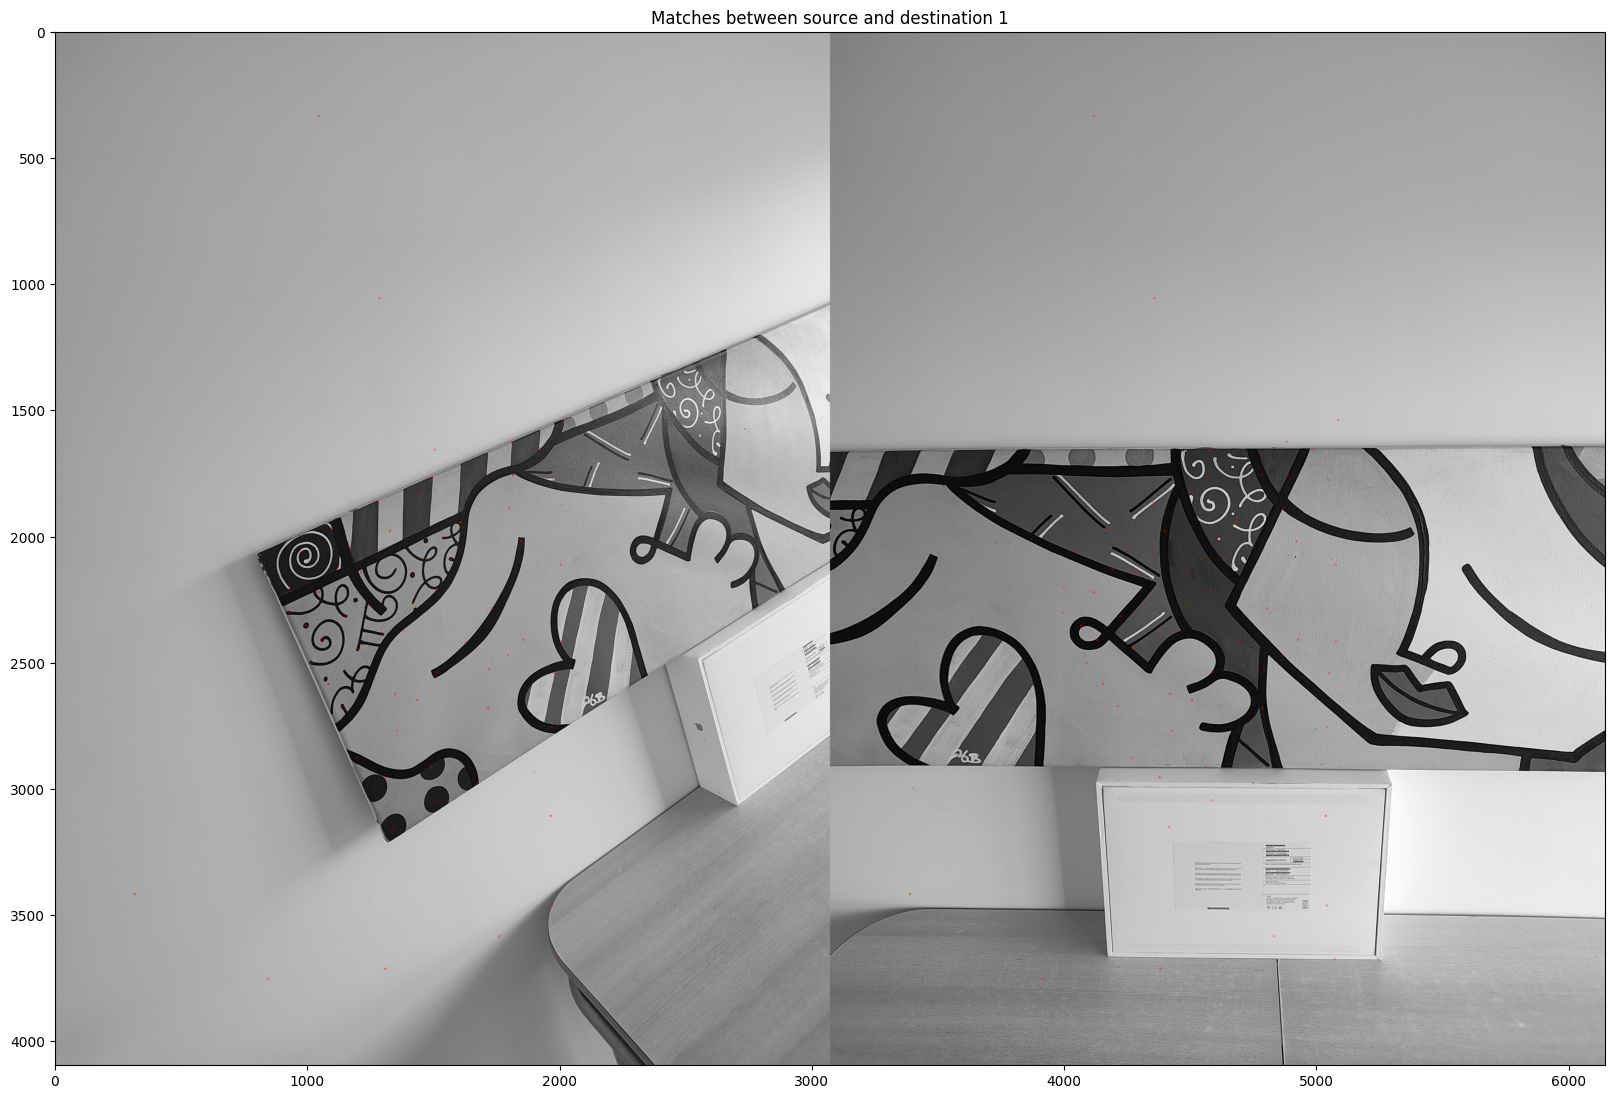

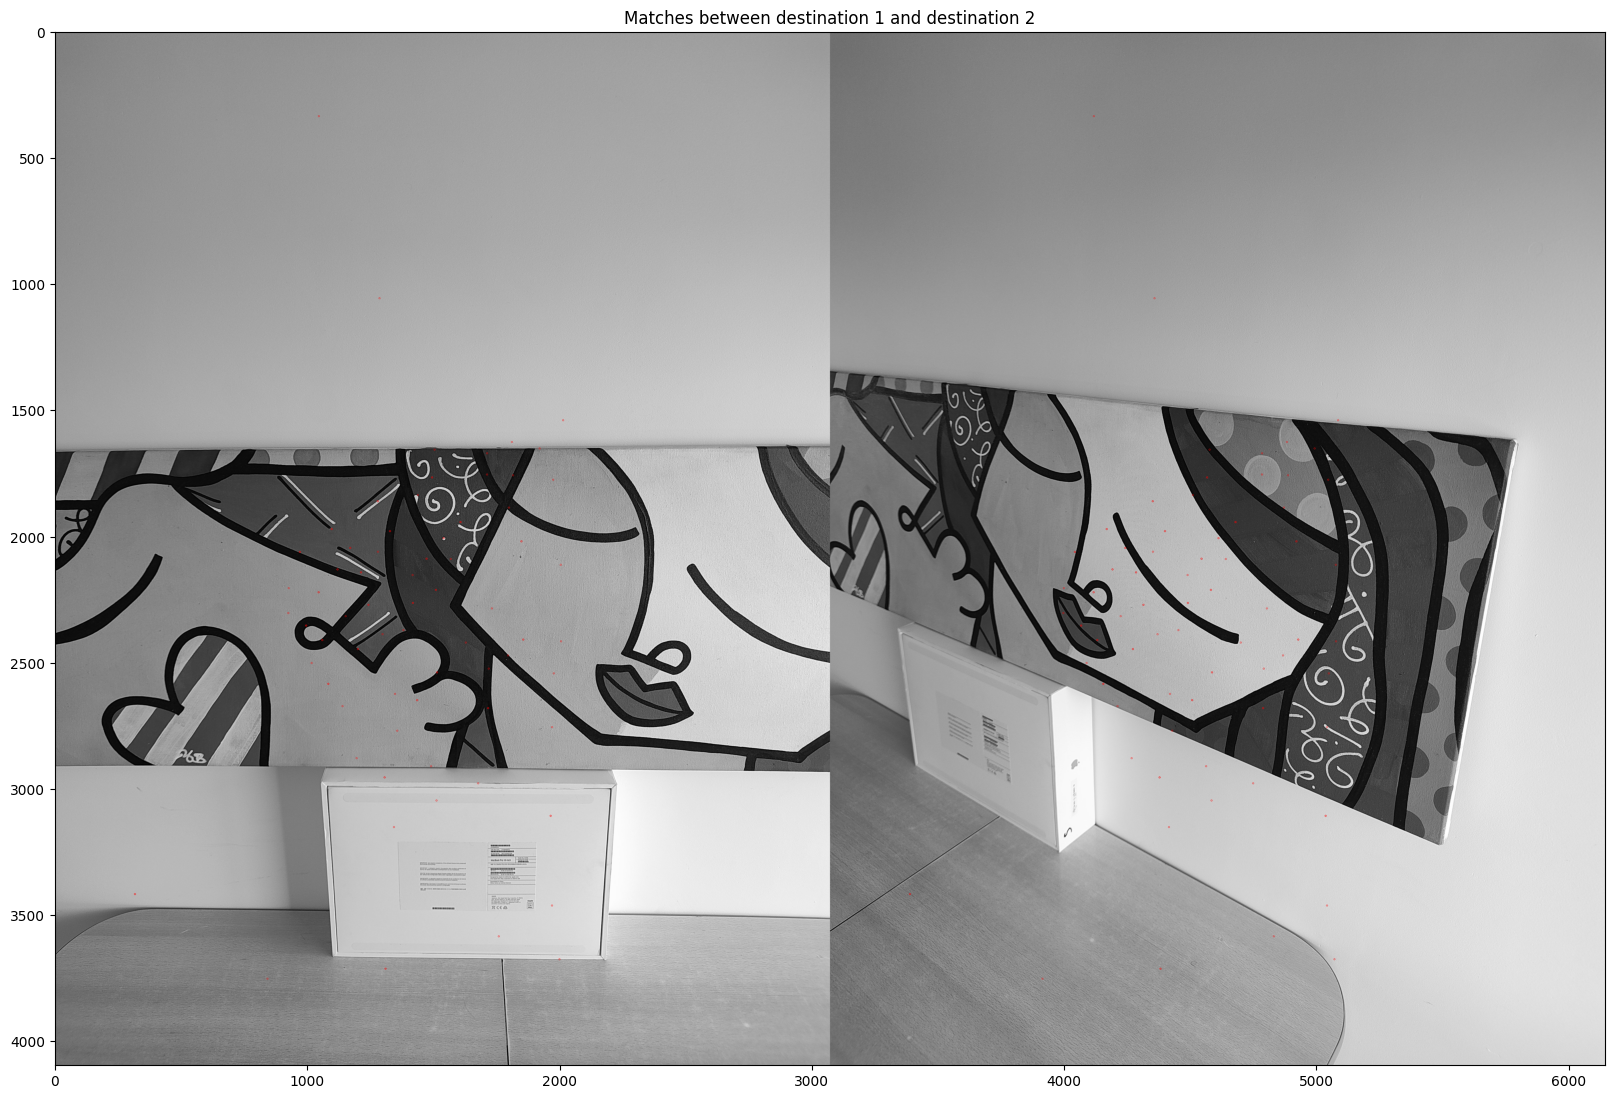

In [102]:
# Draw only good matches
draw_params_01 = dict(matchColor=(0, 255, 0),singlePointColor=(255, 0, 0),matchesMask=matchesMask01,flags=cv2.DrawMatchesFlags_DEFAULT)
draw_params_12 = dict(matchColor=(0, 255, 0),singlePointColor=(255, 0, 0),matchesMask=matchesMask12,flags=cv2.DrawMatchesFlags_DEFAULT)

img_matches01 = cv2.drawMatchesKnn(cuadro0, anms_kp0, cuadro1, anms_kp1, matches01, None, **draw_params_01)
img_matches12 = cv2.drawMatchesKnn(cuadro1, anms_kp1, cuadro2, anms_kp2, matches12, None, **draw_params_12)

plt.figure(figsize=(20, 16))
plt.imshow(img_matches01)
plt.title("Matches between source and destination 1")
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(img_matches12)
plt.title("Matches between destination 1 and destination 2")
plt.show()

In [82]:
def get_good_matches(matches, matchesMask):
    """ Get the good matches from the matches and matchesMask """
    good_matches = []
    for i, (m, n) in enumerate(matches):
        if matchesMask[i][0] == 1:
            good_matches.append(m)
    return good_matches

def find_homography(kp1, kp2, matches):
    """ Find the homography matrix between two images """
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)  # The reshape is needed to convert the list of points to the shape (n,1,2). n=-1 means the number of points is unknown 
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) # 5.0 is the threshold to determine if a point is an inlier or not. The lower the threshold, the more strict the RANSAC algorithm is.
    return H

In [83]:
# Now we want to find the homography matrix that maps the source image to the destination image
good_matches01 = get_good_matches(matches01, matchesMask01)
good_matches12 = get_good_matches(matches12, matchesMask12)

print('Number of good matches:', len(good_matches01)) # remember: minimum matches needed to find the homography matrix is 4 (each match provides 2 equations)
print('Number of good matches:', len(good_matches12))

# Find homographies
H01 = find_homography(kp0, kp1, good_matches01)
H12 = find_homography(kp1, kp2, good_matches12)

Number of good matches: 51
Number of good matches: 14


In [144]:
def warp_images(img1, img2, H):
    """ Warp img1 to img2 using the homography matrix H """
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2) # Coordinates of the 4 corners of the source image
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2) # Coordinates of the 4 corners of the destination image
    pts1_transformed = cv2.perspectiveTransform(pts1, H) # Apply the homography matrix to the source image corners to find the corresponding corners in the destination image
    
    pts = np.concatenate((pts2, pts1_transformed), axis=0) # Concatenate the corners of the destination image and the corners of the source image warped to the destination image
    
    [x_min, y_min] = np.int32(pts.min(axis=0).ravel() - 0.5) # Find the min and max x and y coordinates of the corners of the warped source image in the destination image (subtract 0.5 to round down) 
    [x_max, y_max] = np.int32(pts.max(axis=0).ravel() + 0.5) 
    
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]]) # Translation matrix 

    img1_warp = cv2.warpPerspective(img1, H_translation.dot(H), (x_max-x_min, y_max-y_min))

    if img1.shape == img2.shape:
        img1_warp[translation_dist[1]:h1 + translation_dist[1], translation_dist[0]:w1 + translation_dist[0]] = img2
        result = img1_warp
    else:
        result = np.zeros((y_max - y_min, x_max - x_min), dtype=img2.dtype)
        result[translation_dist[1]:h2 + translation_dist[1], translation_dist[0]:w2 + translation_dist[0]] = img2
        result = np.maximum(result, img1_warp)
    return result

In [145]:
# Warp images
result01 = warp_images(cuadro0, cuadro1, H01)
H21 = np.linalg.inv(H12)  
result21 = warp_images(cuadro2, cuadro1, H21)


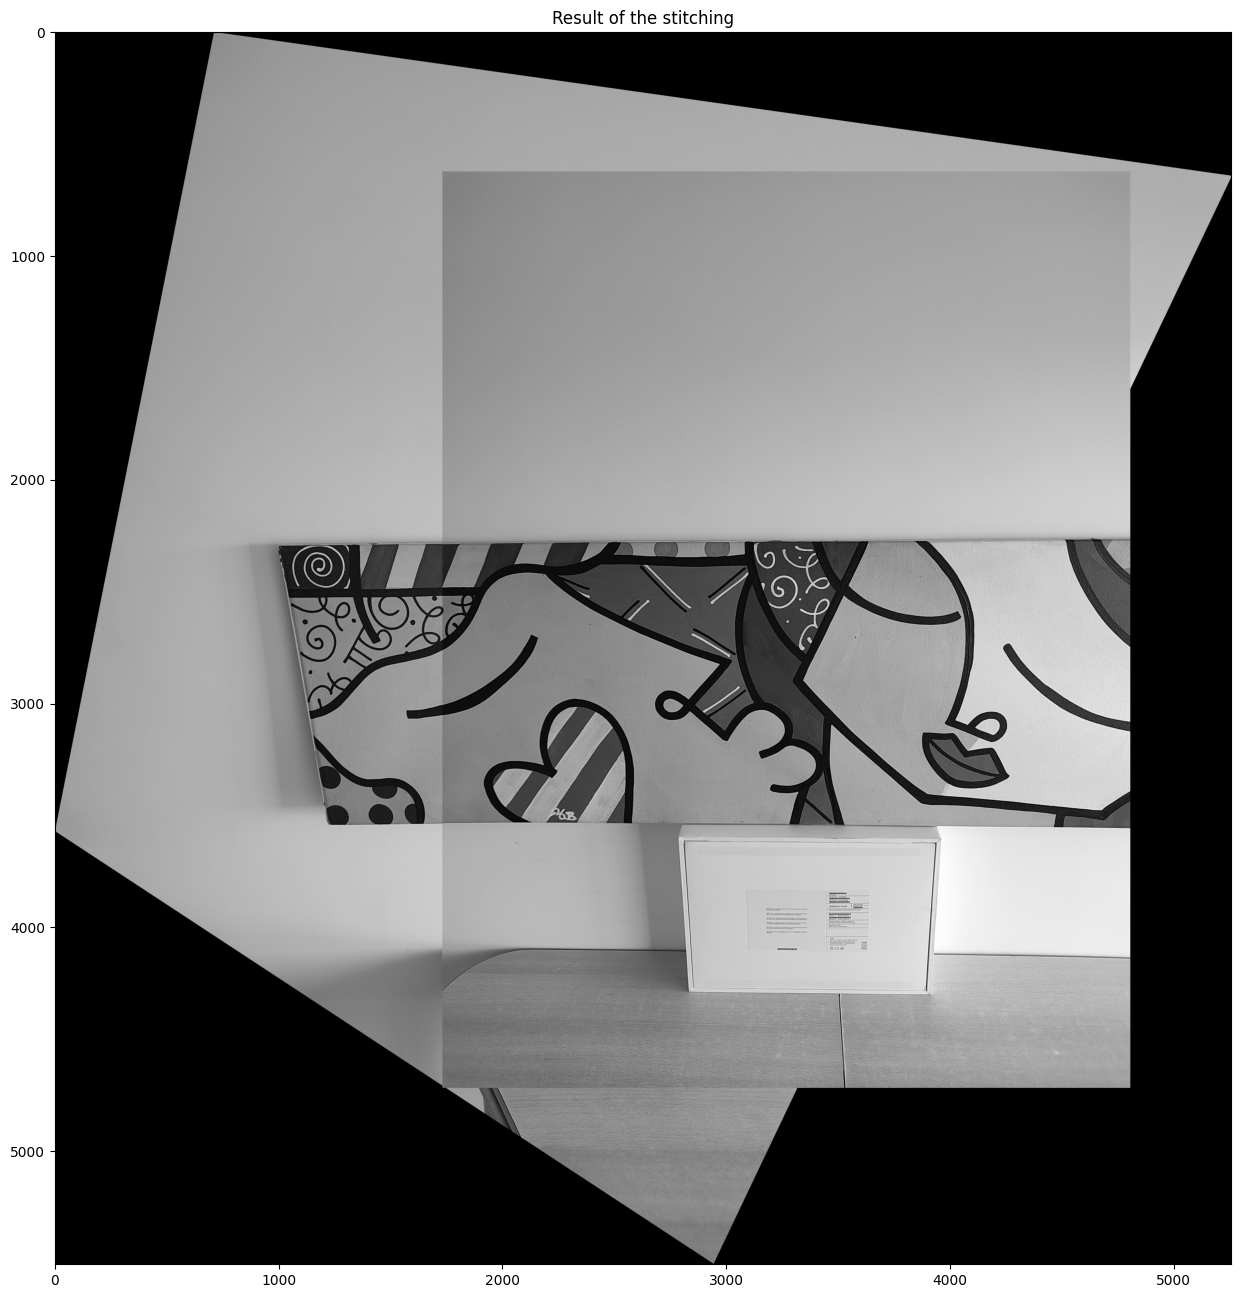

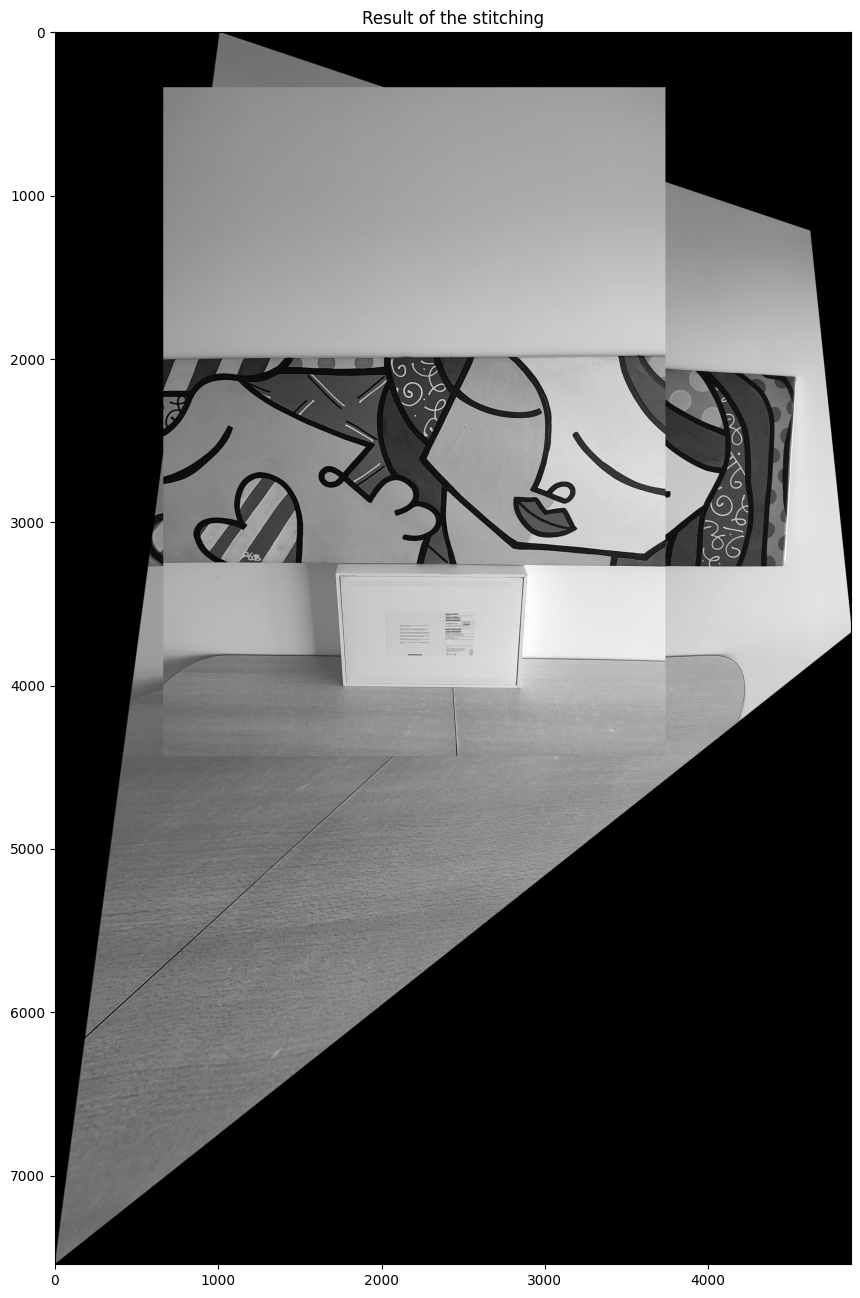

In [146]:
# Display result 
plt.figure(figsize=(20, 16))
plt.imshow(result01, cmap='gray')
plt.title("Result of the stitching")
plt.show()

plt.figure(figsize=(20, 16))
plt.imshow(result21, cmap='gray')
plt.title("Result of the stitching")
plt.show()

In [147]:
kp01, des01 = algo.detectAndCompute(result01, None)
kp21, des21 = algo.detectAndCompute(result21, None)

matches, matchesMask = match_descriptors(des01, des21)

good_matches = get_good_matches(matches, matchesMask)
print('Number of good matches:', len(good_matches)) 

H = find_homography(kp01, kp21, good_matches)
result = warp_images(result01, result21, H)

Number of good matches: 14967


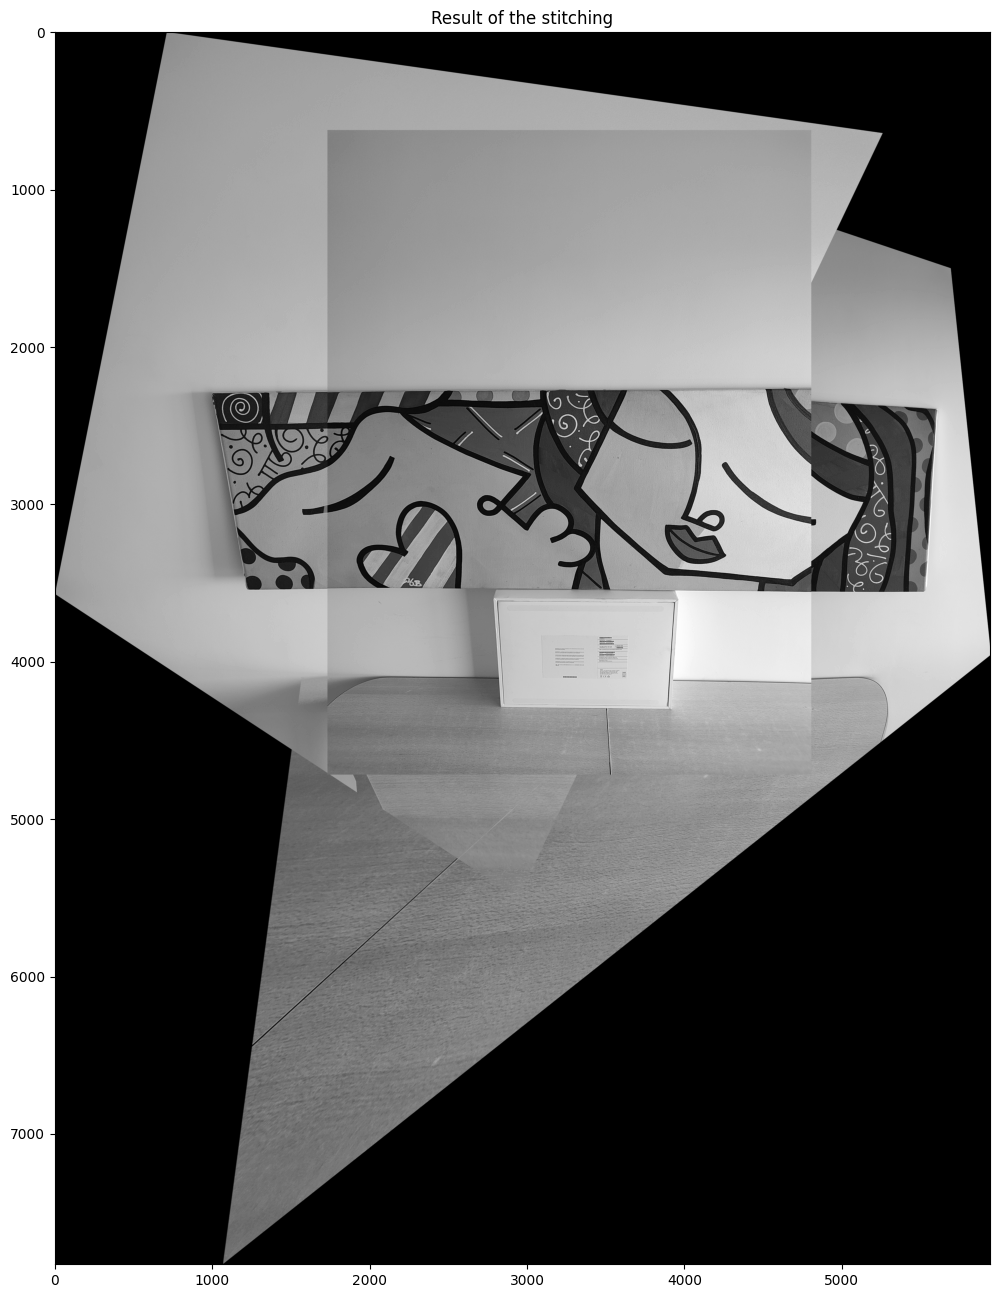

In [148]:
plt.figure(figsize=(20, 16))
plt.imshow(result, cmap='gray')
plt.title("Result of the stitching")
plt.show()